In [ ]:
#Used to install the mpl_finance library used for the candlestick plots
pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

     / 655kB 3.5MB/s
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp36-none-any.whl size=8424 sha256=5e9c7b700666fa263df0f243ef0acddd600802ab212d8b3e05e0fe82eecd71ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kihlcce/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


In [ ]:
#pre-processing the dataset
%run bitcoin.ipynb

In [ ]:
#Importing all the necessary libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
#import mplfinance as mp
import seaborn as sns
from mpl_finance import candlestick_ohlc
#importing packages for the prediction of time-series data
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

#configuring the Environment
color = sns.color_palette()
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [ ]:
#Reading the data into a pandas dataframe. If True and parse_dates is enabled, pandas will attempt 
#to infer the format of the datetime strings in the columns, and if it can be inferred, 
#switch to a faster method of parsing them.
crypto_data = pd.read_csv('bitcoin_price.csv', parse_dates=['Date'])

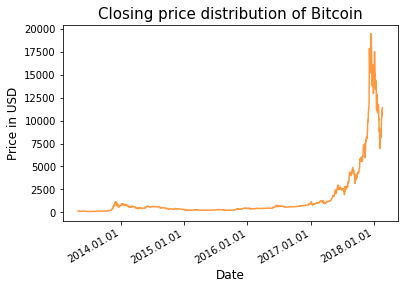

In [ ]:
#Plot of the closing prices of Bitcoin
d = crypto_data[['Date' , 'Close']]
    
d['Date_mpl'] = d['Date'].apply(lambda x: mdates.date2num(x)) # making new column 'Date_mpl' by using date2num lamba function
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(y = d.Close.values, x=d.Date_mpl.values, alpha=0.8, color=color[1], ax=ax)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
title_str = "Closing price distribution of Bitcoin"
plt.title(title_str, fontsize=15)
plt.show()

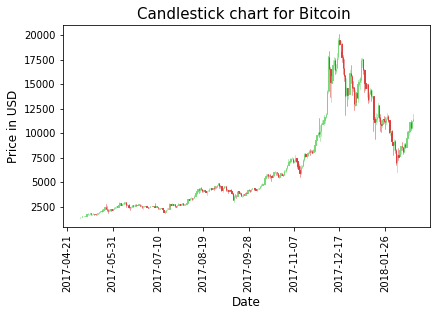

In [ ]:
#Candle stick plot for Bitcoin
df = pd.DataFrame(crypto_data)
fig = plt.figure(figsize=(6,4))
ax1 = plt.subplot2grid((1,1), (0,0))
    
df['Date_mpl'] = df['Date'].apply(lambda x: mdates.date2num(x))
temp_df = df[df['Date']>'2017-05-01']
ohlc = []
for ind, row in temp_df.iterrows():
    ol = [row['Date_mpl'],row['Open'], row['High'], row['Low'], row['Close'], row['Volume']]
    ohlc.append(ol)

candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.xlabel("Date", fontsize=12)
plt.xticks(rotation='vertical')
plt.ylabel("Price in USD", fontsize=12 )
title_str = "Candlestick chart for Bitcoin "
plt.title(title_str, fontsize=15)
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.show()

In [ ]:
#Creating a data frame which contains only the Date and Close prices of the Bitcoin dataset
df_bitcoin = pd.DataFrame(crypto_data)

df_bitcoin = df_bitcoin[['Date','Close']]
df_bitcoin.set_index('Date', inplace = True)

In [ ]:
#Performing the Dickey Fuller test to check if data is stationary
from statsmodels.tsa.stattools import adfuller

# create a difference
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return pd.Series(diff)

#series = read_csv('dataset.csv')
X = df_bitcoin.values
# difference data
stationary = difference(X)
stationary.index = df_bitcoin.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.631803
p-value: 0.000001
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


The results show that the test statistic value -5.631803 is smaller than the critical value at 5% of -2.893. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1.


The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.

We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

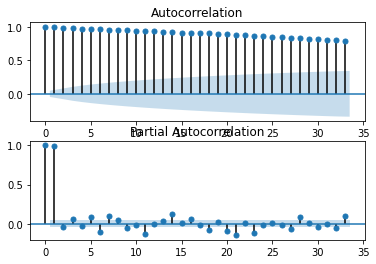

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure()
pyplot.subplot(211)
plot_acf(df_bitcoin, ax=pyplot.gca())

pyplot.subplot(212)

plot_pacf(df_bitcoin, ax=pyplot.gca())
pyplot.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.



                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1759
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -12013.312
Method:                       css-mle   S.D. of innovations            223.772
Date:                Sun, 29 Nov 2020   AIC                          24040.624
Time:                        17:48:57   BIC                          24078.932
Sample:                    02-19-2018   HQIC                         24054.781
                         - 04-28-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.4546      6.170     -1.046      0.296     -18.548       5.639
ar.L1.D.Close     0.1094      0.023      4.663      0.000       0.063       0.155
ar.L2.D.Close    -0.0664      0.024     

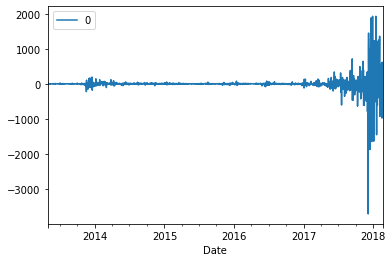

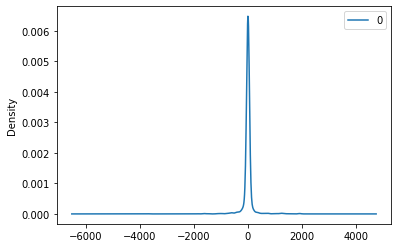

                 0
count  1759.000000
mean      0.033425
std     223.924704
min   -3704.711088
25%      -3.513841
50%       4.783996
75%      11.521174
max    1931.996188


In [ ]:
# fit model
model = ARIMA(df_bitcoin, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Test MSE: 1518.180


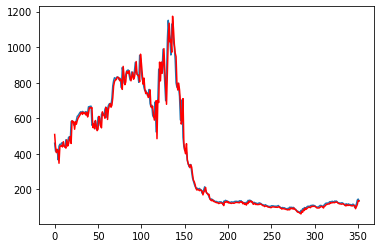

In [ ]:
X = df_bitcoin.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Lambda: -0.307054


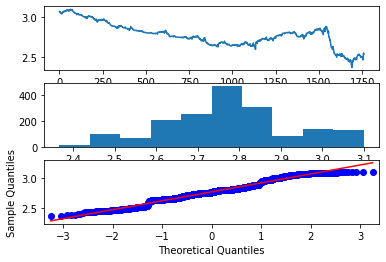

In [ ]:
#The Box-Cox transform is a method that is able to evaluate a suite of power transforms,
# including, but not limited to, log, square root, and reciprocal transforms of the data.

The example below performs a log transform of the data and generates some plots to review the effect on the time series.
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
df_bitcoin = df_bitcoin['Close']
X = df_bitcoin.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

Some observations from these plots are follows:

The large fluctuations have been smoothened to some degree from the line plot of the time series.
The histogram shows a non uniform distribution of values.
The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution.